### 0. Import libraries and load data

In [1]:
import os
import json
import tiktoken
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pypdf import PdfReader
from matplotlib import pyplot as plt

sns.set()

MAX_TOKENS = 1024
FLYERS_FOLDER_PATH = "../fetch_flyers/flyers/"
SECTIONS_FILE_PATH = "./data/flyers_wo_outliers.json"
GROUPED_SECTIONS_FILE_PATH = "./data/grouped_sections.json"
PLOT_STORAGE_PATH = "./data/tokens_distribution.png"

In [2]:
# load results
with open(SECTIONS_FILE_PATH) as file:
    sections_data = dict(json.load(file))


### 1. Analyze number of tokens

##### 1.1 Count number of tokens per section

In [3]:
def analyze_length(text_tokens, title):
    percentage_of_long_texts = len(np.where(np.array(text_tokens) > MAX_TOKENS)[0]) / len(text_tokens)
    print(f"Percentage of sections longer than {MAX_TOKENS} tokens is {percentage_of_long_texts * 100}%")

    min_tokens = min(text_tokens)
    max_tokens = max(text_tokens)

    print(f"Min number of tokens per section: {min_tokens}\nMax number of tokens per section: {max_tokens}")

    plt.boxplot(text_tokens)
    plt.title(title)

In [4]:
section_tokens = []
encoder = tiktoken.get_encoding("cl100k_base")

# iterate over PDFs
for file_name, data in sections_data.items():

    # iterate over sections
    for header, section in data.items():
        text = f"Filename: {file_name}\nTitle: {header}\n{section}"
        section_tokens.append(len(encoder.encode(text)))

Percentage of sections longer than 1024 tokens is 0.5220944309927361%
Min number of tokens per section: 27
Max number of tokens per section: 2882


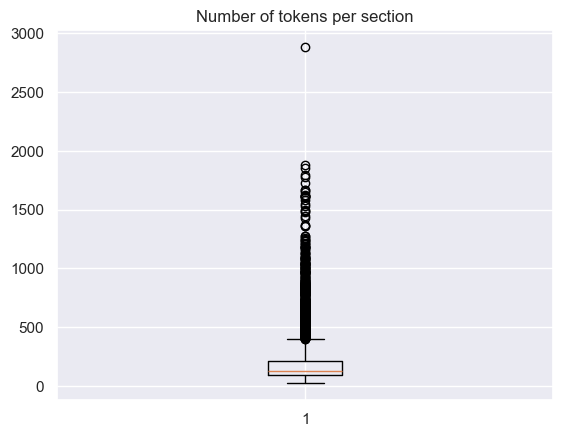

In [5]:
analyze_length(section_tokens, "Number of tokens per section")

##### 1.2. Count number of tokens per flyer page

In [6]:
pages_tokens = []
flyer_names = os.listdir(FLYERS_FOLDER_PATH)

for flyer_name in tqdm(flyer_names):
    # parse PDFs with the same package used during the RAG
    reader = PdfReader(FLYERS_FOLDER_PATH + flyer_name)
    
    for page in reader.pages:
        pages_tokens.append(len(encoder.encode(page.extract_text())))

100%|██████████| 1320/1320 [03:00<00:00,  7.31it/s]


Percentage of sections longer than 1024 tokens is 22.29016120066704%
Min number of tokens per section: 0
Max number of tokens per section: 2849


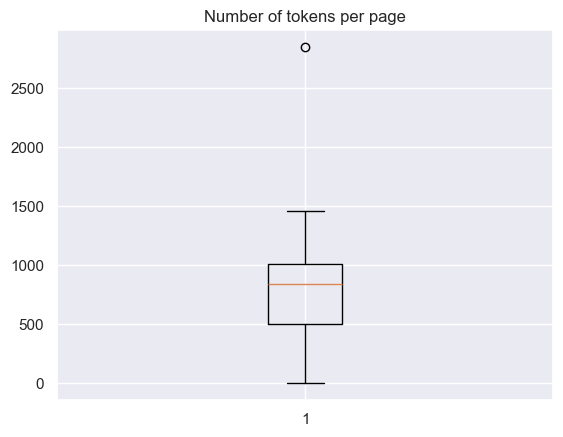

In [7]:
analyze_length(pages_tokens, "Number of tokens per page")

### 2. Group sections

In [8]:
grouped_sections = dict()
grouped_section_tokens = []

# iterate over PDFs
for file_name, data in sections_data.items():
    current_grouped_sections = dict()
    text = ""
    tokens = 0
    page_index = 0

    # iterate over sections
    for header, section in data.items():
        text_ = f"Title: {header}\n{section}\n\n"
        tokens_ = len(encoder.encode(text_))
                      
        # if there are more than max tokens, store all previous sections in a page
        if tokens + tokens_ > MAX_TOKENS:
            current_grouped_sections["page_" + str(page_index)] = text[:-2]
            grouped_section_tokens.append(tokens)

            # current section is added to the next page
            page_index += 1
            text = text_
            tokens = tokens_

        # lese add section to current page
        else:
            text += text_
            tokens += tokens_

    # if text remained unadded to any page, add it as a new page
    if text != "":
        current_grouped_sections["page_" + str(page_index)] = text[:-2]
        grouped_section_tokens.append(tokens)

    # add the current pages to the corresponding flyer
    grouped_sections[file_name] = current_grouped_sections

Percentage of sections longer than 1024 tokens is 2.1516054286660045%
Min number of tokens per section: 0
Max number of tokens per section: 2867


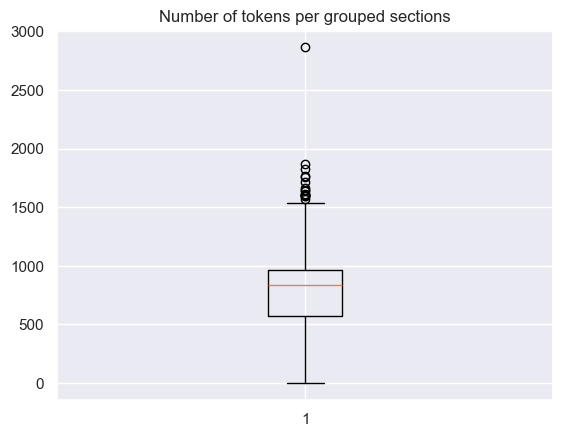

In [9]:
analyze_length(grouped_section_tokens, "Number of tokens per grouped sections")

In [10]:
# save data locally in JSON format
with open(GROUPED_SECTIONS_FILE_PATH, "w") as file:
    file.write(json.dumps(grouped_sections, indent=4))

### 3. Plot distribution of tokens by text type

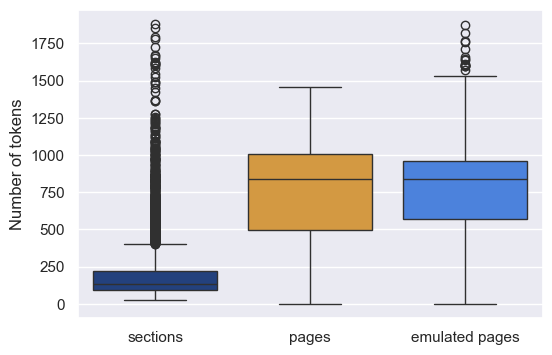

In [15]:
palette = sns.color_palette("coolwarm", 10)
colors = [palette[0], palette[3], palette[-1]]


fig, _ = plt.subplots(1, 1)
fig.set_size_inches(6, 4)
tokens_no = {
    "sections": sorted(section_tokens)[:-1],
    "pages": sorted(pages_tokens)[:-1],
    "emulated pages": sorted(grouped_section_tokens)[:-1],
}
tokens_no_df = pd.DataFrame.from_dict(tokens_no, orient="index").transpose()

sns.boxplot(data=tokens_no_df, palette=["#143c8c", "#eb9e2a", "#347cf4"])
plt.ylabel("Number of tokens")
fig.savefig(PLOT_STORAGE_PATH, dpi=300)

plt.show()
